In [17]:
!pip install pyspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Defaulting to user installation because normal site-packages is not writeable
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
!pip install seaborn
!pip install pyarrow
!pip install sparkmagic

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sparkmagic-0.20.5.tar.gz (44 kB)
  Preparing metadata (setup.py) ... done
  Using cached hdijupyterutils-0.20.5.tar.gz (5.1 kB)
  Preparing metadata (setup.py) ... done
  Using cached autovizwidget-0.20.5.tar.gz (9.0 kB)
  Preparing metadata (setup.py) ... done
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached notebook-6.5.4-py3-none-any.whl (529 kB)
  Using cached requests_kerberos-0.14.0-py2.py3-none-any.whl (11 kB)
  Using cached nest_asyncio-1.5.5-py3-none-any.whl (5.2 kB)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached argon2_cffi-21.3.0-py3-none-any.whl (14 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
  Using cached nbconve

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

import numpy as np
import pandas as pdS

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .master('local[10]') \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .appName('BDF2') \
    .getOrCreate()

plt.style.use('ggplot')
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/11 05:33:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [31]:
# data = spark.read.parquet("hdfs://20.121.35.246:9000/nyc_trips")	
data = spark.read.parquet("hdfs://20.121.35.246:9000/nyc_trips/fhvhv_tripdata_2020-*")	

In [4]:
data.createOrReplaceTempView('TAXI')

In [4]:
data

DataFrame[hvfhs_license_num: string, dispatching_base_num: string, originating_base_num: string, request_datetime: timestamp_ntz, on_scene_datetime: timestamp_ntz, pickup_datetime: timestamp_ntz, dropoff_datetime: timestamp_ntz, PULocationID: bigint, DOLocationID: bigint, trip_miles: double, trip_time: bigint, base_passenger_fare: double, tolls: double, bcf: double, sales_tax: double, congestion_surcharge: double, airport_fee: double, tips: double, driver_pay: double, shared_request_flag: string, shared_match_flag: string, access_a_ride_flag: string, wav_request_flag: string, wav_match_flag: string]

In [5]:
data.count()

143309871

In [32]:
data = data.drop(
    "wav_match_flag",
    "wav_request_flag", 
    "hvfhs_license_num",
    "dispatching_base_num",
    "originating_base_num",
    "request_datetime",
    "on_scene_datetime",
    "dropoff_datetime",
    "tolls",
    "bcf",
    "sales_tax",
    "congestion_surcharge",
    "airport_fee",
    "shared_request_flag",
    "shared_match_flag",
    "access_a_ride_flag"
    )

In [33]:
data.printSchema()

root
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)



## Evaluamos el Boxplot de la variable Tips

In [12]:
pdf = data.select('tips').sample(0.01).toPandas()

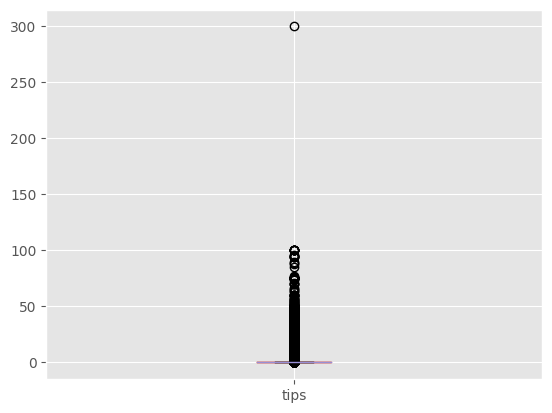

In [13]:
pdf.boxplot()
plt.show()

In [14]:
pdf2 = data.filter(data.tips.between(0, 10)).select('tips').sample(0.01).toPandas()

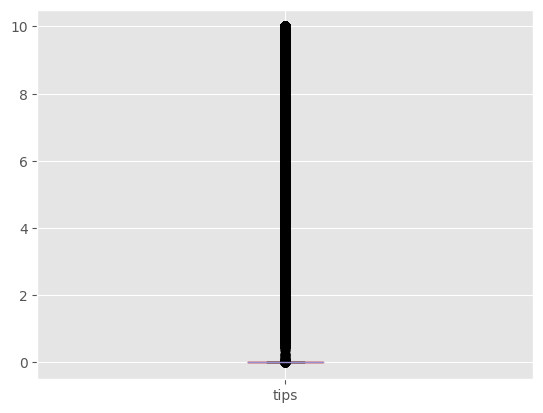

In [15]:
pdf2.boxplot()
plt.show()

In [16]:
pdf3 = data.filter(data.tips.between(0, 1)).select('tips').sample(0.01).toPandas()

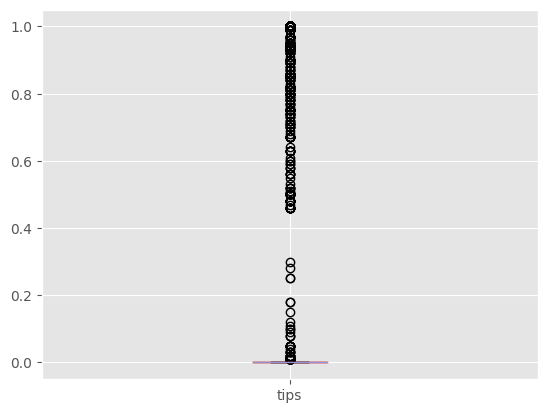

In [17]:
pdf3.boxplot()
plt.show()

## Seleccionamos rango entre 0 a 10

In [19]:
data.filter(data.tips.between(0, 10)).select('tips').describe().toPandas()

,summary,tips
0,count,142302187
1,mean,0.42880149958616626
2,stddev,1.375721933376247
3,min,0.0
4,max,10.0


In [34]:
data_no_outliers = data.filter(data.tips.between(0, 10))

## Added Variables

In [35]:
data_no_outliers = data_no_outliers.withColumn('dayofweek', F.dayofweek(data_no_outliers['pickup_datetime']))
data_no_outliers = data_no_outliers.withColumn('hour', F.hour(data_no_outliers['pickup_datetime']))

# peak hours, Monday-Friday between 4PM-8PM
data_no_outliers = data_no_outliers.withColumn('peak_hours', F.when(
    (data_no_outliers['hour']>=16) & (data_no_outliers['hour']<20) & (data_no_outliers['dayofweek']!=7)&(data_no_outliers['dayofweek']!=0), 1).otherwise(0))

# night hours, $0.5 of additional surcharge between 8PM - 6AM.
data_no_outliers = data_no_outliers.withColumn('night_time', F.when(
    (data_no_outliers['hour']>=20) | (data_no_outliers['hour']<6), 1).otherwise(0))

## Persist sample of values in device memory for evaluation

In [37]:
dno_small = data_no_outliers.sample(0.01)

In [38]:
from pyspark import StorageLevel
dno_small.explain()
dno_small.persist(StorageLevel.MEMORY_ONLY)
dno_small.count()

== Physical Plan ==
*(1) Sample 0.0, 1.0E-4, false, -7760117040415683478
+- *(1) Project [pickup_datetime#7003, PULocationID#7005L, DOLocationID#7006L, trip_miles#7007, trip_time#7008L, base_passenger_fare#7009, tips#7015, driver_pay#7016, dayofweek#7055, hour#7065, CASE WHEN ((((hour#7065 >= 16) AND (hour#7065 < 20)) AND NOT (dayofweek#7055 = 7)) AND NOT (dayofweek#7055 = 0)) THEN 1 ELSE 0 END AS peak_hours#7076, CASE WHEN ((hour#7065 >= 20) OR (hour#7065 < 6)) THEN 1 ELSE 0 END AS night_time#7088]
   +- *(1) Project [pickup_datetime#7003, PULocationID#7005L, DOLocationID#7006L, trip_miles#7007, trip_time#7008L, base_passenger_fare#7009, tips#7015, driver_pay#7016, dayofweek(cast(pickup_datetime#7003 as date)) AS dayofweek#7055, hour(pickup_datetime#7003, Some(America/Lima)) AS hour#7065]
      +- *(1) Filter ((isnotnull(tips#7015) AND (tips#7015 >= 0.0)) AND (tips#7015 <= 10.0))
         +- *(1) ColumnarToRow
            +- FileScan parquet [pickup_datetime#7003,PULocationID#7005L,DO

14215

## Correlación entre variables continuas vs tips, Naive

In [44]:
naive_variables = ['dayofweek',
                        'hour',
                        'peak_hours',
                        'night_time',
                        'trip_time',
                        'PULocationID',
                        'DOLocationID']

for i in naive_variables:
    print( "Correlation to [tips] for ", i, dno_small.stat.corr('tips',i))

Correlation to [tips] for  dayofweek 0.0077302797789898904
Correlation to [tips] for  hour -0.0006409069795949138
Correlation to [tips] for  peak_hours -0.006092551862727781
Correlation to [tips] for  night_time -0.032296421856526154
Correlation to [tips] for  trip_time 0.10749997471165998
Correlation to [tips] for  PULocationID 0.03508541046982388
Correlation to [tips] for  DOLocationID 0.014307492981689025


## Correlación entre variables refinadas vs tips, Refined

In [43]:
refined_variables = [
    "base_passenger_fare",
    "driver_pay",
    "trip_miles",
    "trip_time",
]

for i in refined_variables:
    print( "Correlation to [tips] for ", i, dno_small.stat.corr('tips',i))

Correlation to [tips] for  base_passenger_fare 0.1205635709139525
Correlation to [tips] for  driver_pay 0.10540002959881452
Correlation to [tips] for  trip_miles 0.09094848869960084
Correlation to [tips] for  trip_time 0.10749997471165998


## Modeling

## Train test split

In [8]:
(trainingData, testData) = data_no_outliers.randomSplit([0.7, 0.3], seed=66)

## Assemble features and variables

In [9]:
assembler = VectorAssembler(
    inputCols=naive_variables,
    outputCol='features')

In [10]:
trainingData = assembler.setHandleInvalid("skip").transform(trainingData)
testData = assembler.setHandleInvalid("skip").transform(testData)

In [11]:
trainingData = trainingData.select(trainingData.features,trainingData.tips)
testData = testData.select(testData.features,testData.tips)

## To device memory

In [36]:
from pyspark import StorageLevel
trainingData.explain()
trainingData.persist(StorageLevel.MEMORY_ONLY)
trainingData.count()

== Physical Plan ==
*(1) Project [features#7365, tips#74]
+- *(1) Project [tips#74, UDF(struct(dayofweek_double_VectorAssembler_cff052d9436f, cast(dayofweek#123 as double), hour_double_VectorAssembler_cff052d9436f, cast(hour#130 as double), peak_hours_double_VectorAssembler_cff052d9436f, cast(peak_hours#138 as double), night_time_double_VectorAssembler_cff052d9436f, cast(night_time#147 as double), trip_time_double_VectorAssembler_cff052d9436f, cast(trip_time#67L as double), PULocationID_double_VectorAssembler_cff052d9436f, cast(PULocationID#64L as double), DOLocationID_double_VectorAssembler_cff052d9436f, cast(DOLocationID#65L as double))) AS features#7365]
   +- *(1) Filter atleastnnonnulls(7, dayofweek#123, hour#130, peak_hours#138, night_time#147, trip_time#67L, PULocationID#64L, DOLocationID#65L)
      +- *(1) Sample 0.0, 0.7, false, 66
         +- *(1) Project [PULocationID#64L, DOLocationID#65L, trip_time#67L, tips#74, dayofweek#123, hour#130, peak_hours#138, night_time#147]
    

99621445

## Decision Tree Regression 1, fitting

In [37]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol='tips')

# Model fitting
model = dt.fit(trainingData)

23/07/11 02:31:40 WARN MemoryStore: Not enough space to cache rdd_174_8 in memory! (computed 332.1 MiB so far)
23/07/11 02:31:40 WARN BlockManager: Persisting block rdd_174_8 to disk instead.
23/07/11 02:31:41 WARN MemoryStore: Not enough space to cache rdd_174_5 in memory! (computed 332.1 MiB so far)
23/07/11 02:31:41 WARN BlockManager: Persisting block rdd_174_5 to disk instead.
23/07/11 02:31:41 WARN MemoryStore: Not enough space to cache rdd_174_1 in memory! (computed 332.1 MiB so far)
23/07/11 02:31:41 WARN BlockManager: Persisting block rdd_174_1 to disk instead.
23/07/11 02:31:41 WARN MemoryStore: Not enough space to cache rdd_174_19 in memory! (computed 332.1 MiB so far)
23/07/11 02:31:41 WARN BlockManager: Persisting block rdd_174_19 to disk instead.
23/07/11 02:31:41 WARN MemoryStore: Not enough space to cache rdd_174_17 in memory! (computed 332.1 MiB so far)
23/07/11 02:31:41 WARN BlockManager: Persisting block rdd_174_17 to disk instead.
23/07/11 02:31:41 WARN MemoryStore: 

## Evaluation on test data

In [50]:
predictions = model.transform(testData)
predictions.persist(StorageLevel.MEMORY_ONLY)

rmse = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(predictions)
mae = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(predictions)
r2 = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(predictions)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

RMSE:  1.361792878777681
MAE:  0.747347768649097
R-squared:  0.02040292689396983


In [51]:
predictions.unpersist(True)

DataFrame[features: vector, tips: double, prediction: double]

--------------------------------------------

## Train test split

In [45]:
(trainingData1, testData1) = data_no_outliers.randomSplit([0.7, 0.3], seed=66)

## Assemble features and variables

In [47]:
assembler = VectorAssembler(
    inputCols=refined_variables,
    outputCol='features')

In [48]:
trainingData1 = assembler.setHandleInvalid("skip").transform(trainingData1)
testData1 = assembler.setHandleInvalid("skip").transform(testData1)

In [49]:
trainingData1 = trainingData1.select(trainingData1.features,trainingData1.tips)
testData1 = testData1.select(testData1.features,testData1.tips)

## To device memory

In [50]:
from pyspark import StorageLevel
trainingData1.explain()
trainingData1.persist(StorageLevel.MEMORY_ONLY)
trainingData1.count()

== Physical Plan ==
*(1) Project [features#23280, tips#7015]
+- *(1) Project [tips#7015, UDF(struct(base_passenger_fare, base_passenger_fare#7009, driver_pay, driver_pay#7016, trip_miles, trip_miles#7007, trip_time_double_VectorAssembler_77d26040a5dc, cast(trip_time#7008L as double))) AS features#23280]
   +- *(1) Filter atleastnnonnulls(4, base_passenger_fare#7009, driver_pay#7016, trip_miles#7007, trip_time#7008L)
      +- *(1) Sample 0.0, 0.7, false, 66
         +- *(1) Project [trip_miles#7007, trip_time#7008L, base_passenger_fare#7009, tips#7015, driver_pay#7016]
            +- *(1) Sort [pickup_datetime#7003 ASC NULLS FIRST, PULocationID#7005L ASC NULLS FIRST, DOLocationID#7006L ASC NULLS FIRST, trip_miles#7007 ASC NULLS FIRST, trip_time#7008L ASC NULLS FIRST, base_passenger_fare#7009 ASC NULLS FIRST, tips#7015 ASC NULLS FIRST, driver_pay#7016 ASC NULLS FIRST, dayofweek#7055 ASC NULLS FIRST, hour#7065 ASC NULLS FIRST, peak_hours#7076 ASC NULLS FIRST, night_time#7088 ASC NULLS FIR

99621445

## Decision Tree Regression 2, fitting

In [51]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol='tips')

# Model fitting
model1 = dt.fit(trainingData1)

23/07/11 06:00:00 WARN MemoryStore: Not enough space to cache rdd_400_19 in memory! (computed 227.2 MiB so far)
23/07/11 06:00:00 WARN BlockManager: Persisting block rdd_400_19 to disk instead.
23/07/11 06:00:03 WARN MemoryStore: Not enough space to cache rdd_400_1 in memory! (computed 227.2 MiB so far)
23/07/11 06:00:03 WARN BlockManager: Persisting block rdd_400_1 to disk instead.
23/07/11 06:00:03 WARN MemoryStore: Not enough space to cache rdd_400_8 in memory! (computed 227.2 MiB so far)
23/07/11 06:00:03 WARN BlockManager: Persisting block rdd_400_8 to disk instead.
23/07/11 06:00:03 WARN MemoryStore: Not enough space to cache rdd_400_11 in memory! (computed 227.2 MiB so far)
23/07/11 06:00:03 WARN BlockManager: Persisting block rdd_400_11 to disk instead.
23/07/11 06:00:03 WARN MemoryStore: Not enough space to cache rdd_400_5 in memory! (computed 227.2 MiB so far)
23/07/11 06:00:03 WARN BlockManager: Persisting block rdd_400_5 to disk instead.
23/07/11 06:00:06 WARN MemoryStore: 

In [53]:
predictions2 = model1.transform(testData1)
predictions2.persist(StorageLevel.MEMORY_ONLY)

rmse = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="rmse")
rmse = rmse.evaluate(predictions2)
mae = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="mae")
mae = mae.evaluate(predictions2)
r2 = RegressionEvaluator(labelCol="tips", predictionCol="prediction", metricName="r2")
r2 = r2.evaluate(predictions2)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

RMSE:  1.3542757115143698
MAE:  0.7442312316671168
R-squared:  0.031202710373630205


In [54]:
predictions2.unpersist(True)

DataFrame[features: vector, tips: double, prediction: double]